In [53]:
from math import sqrt
from random import seed

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

plt.rc('font', family='serif', size=8)
plt.rc('text', usetex=True)
th.manual_seed(0)
seed(0)

In [54]:
def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb


class AssMem(nn.Module):
    def __init__(self, E, U, W, learnable=False):
        """
        E: torch.Tensor
            Input embedding matrix of size $n \times d$,
            where $n$ is the number of tokens and $d$ is the embedding dimension.
        U: torch.Tensor
            Output unembedding matrix of size $d \times m$,
            where $m$ is the number of classes and $d$ is the embedding dimension.
        W: torch.Tensor
            Weight matrix of size $d \times d$, at initialization.
        """
        super().__init__()
        if learnable:
            self.W = nn.Parameter(W)
        else:
            self.W = W
        self.E = E
        self.U = U

    def forward(self, x):
        return self.E[x] @ self.W @ self.U

    def score(self, x):
        out = self.E[x] @ self.W @ self.U
        return F.softmax(out, dim=-1)
    
    def noise_gradient(self, scores, proba):
        return self.E.T @ (scores * proba[:, None]) @ self.U.T

    def signal_gradient(self, all_y, proba):
        gradient = (self.E.T * proba) @ self.U[:, all_y].T
        gradient *= -1
        return gradient

    def population_gradient(self, all_x, all_y, proba):
        scores = self.score(all_x)
        grad = self.noise_gradient(scores, proba)
        grad += self.signal_gradient(all_y, proba)
        return grad

    def SGD_update(self, all_x, all_y, proba, lr, verbose=False):
        grad = self.population_gradient(all_x, all_y, proba)
        self.W -= lr * grad
        if verbose:
            return grad.std()

    def rescaleSGD_update(self, all_x, all_y, proba, lr):
        grad = self.population_gradient(all_x, all_y, proba)
        grad /= grad.std()
        self.W -= lr * grad

    def signSGD_update(self, all_x, all_y, proba, lr):
        grad = self.population_gradient(all_x, all_y, proba)
        self.W -= lr * th.sign(grad)

In [55]:
# number of input tokens
n = 10
# number of output classes
m = 5
# memory dimension
d = 10

# Zipf parameter
alpha = 2

In [56]:
# Population data
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = all_x % m

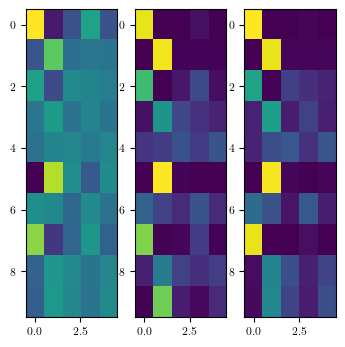

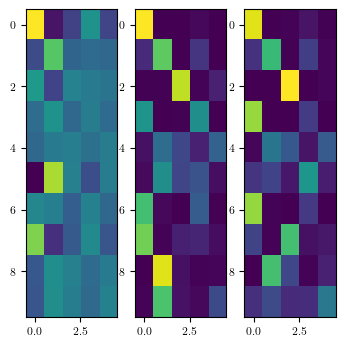

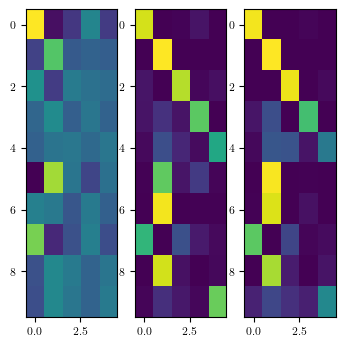

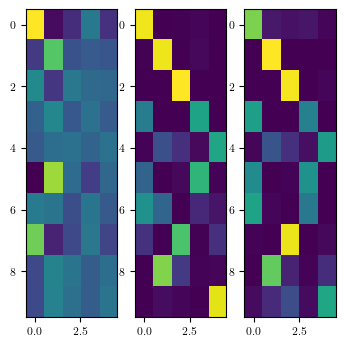

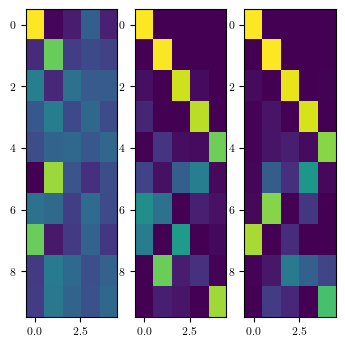

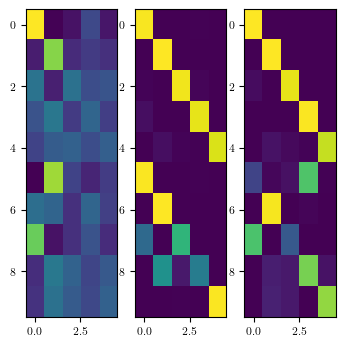

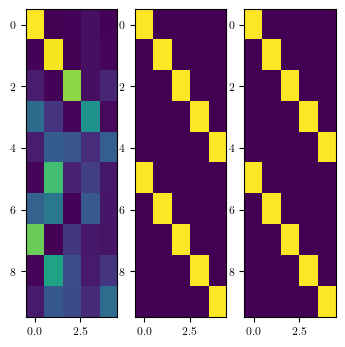

In [87]:
random_init = False
lr = 1.

E = get_embeddings(n, d, norm=False)
U = get_embeddings(m, d, norm=True).T

if random_init:
    W = th.randn(d, d)
else:
    W = th.zeros(d, d)

model_SGD = AssMem(E, U, W)
model_signSGD = AssMem(E, U, W.clone())
model_rescaleSGD = AssMem(E, U, W.clone())
# model_adam = AssMem(E, U, W.clone(), learnable=True)
# opti = th.optim.Adam(model_adam.parameters(), betas=(0, 0), lr=lr)

for i in range(100):
    model_SGD.SGD_update(all_x, all_y, proba, lr)
    model_signSGD.signSGD_update(all_x, all_y, proba, lr)
    model_rescaleSGD.rescaleSGD_update(all_x, all_y, proba, lr)

    # out = model_adam(all_x)
    # loss = (proba * F.cross_entropy(out, all_y, reduction='none')).sum()
    # opti.zero_grad()
    # loss.backward()
    # opti.step()

    if i in [0, 1, 2, 3, 6, 10, 99]:
        img1 = model_SGD.score(all_x)
        img2 = model_signSGD.score(all_x)
        img3 = model_rescaleSGD.score(all_x)

        fig, ax = plt.subplots(1, 3, figsize=(4, 4))
        ax[0].imshow(img1, aspect='auto')
        ax[1].imshow(img2, aspect='auto')
        ax[2].imshow(img3, aspect='auto')
        fig.savefig(f'comparison_{i}.png')

        # fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        # ax.imshow(img1, aspect='auto')
        # ax.set_axis_off()
        # fig.savefig(f'sgd_{i}.png')

        # fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        # ax.imshow(img2, aspect='auto')
        # ax.set_axis_off()
        # fig.savefig(f'sign_sgd_{i}.png')

        # fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        # ax.imshow(img3, aspect='auto')
        # ax.set_axis_off()
        # fig.savefig(f'rescale_sgd_{i}.png')

In [58]:

nb_epochs = 100
nb_trials = 100
random_init = False
lr = 1.

errors = th.zeros(4, nb_trials, nb_epochs)
var = th.zeros(nb_trials, nb_epochs)

for i_t in range(nb_trials):

    E = get_embeddings(n, d, norm=False)
    U = get_embeddings(m, d, norm=True).T

    if random_init:
        W = th.randn(d, d)
    else:
        W = th.zeros(d, d)

    model_SGD = AssMem(E, U, W)
    model_signSGD = AssMem(E, U, W.clone())
    model_rescaleSGD = AssMem(E, U, W.clone())
    model_adam = AssMem(E, U, W.clone(), learnable=True)
    opti = th.optim.Adam(model_adam.parameters(), betas=(0.9, 0), lr=lr)

    for i in range(nb_epochs):
        var[i_t, i] = model_SGD.SGD_update(all_x, all_y, proba, lr, verbose=True)
        model_signSGD.signSGD_update(all_x, all_y, proba, lr)
        model_rescaleSGD.rescaleSGD_update(all_x, all_y, proba, lr)

        out = model_adam(all_x)
        loss = (proba * F.cross_entropy(out, all_y, reduction='none')).sum()
        opti.zero_grad()
        loss.backward()
        opti.step()

        with th.no_grad():
            pred1 = model_SGD.score(all_x).argmax(dim=-1)
            pred2 = model_signSGD.score(all_x).argmax(dim=-1)
            pred3 = model_rescaleSGD.score(all_x).argmax(dim=-1)
            pred4 = model_adam.score(all_x).argmax(dim=-1)
            errors[0, i_t, i] = proba[pred1 != all_y].mean()
            errors[1, i_t, i] = proba[pred2 != all_y].mean()
            errors[2, i_t, i] = proba[pred3 != all_y].mean()
            errors[3, i_t, i] = proba[pred4 != all_y].mean()

    print(i_t, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

In [59]:
errors[th.isnan(errors)] = 0
mean_errors = errors.mean(dim=1)
std_errors = errors.std(dim=1)

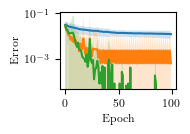

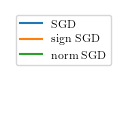

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
a, =  ax.plot(mean_errors[0], label='SGD')
ax.fill_between(np.arange(nb_epochs), mean_errors[0] - std_errors[0], mean_errors[0] + std_errors[0], alpha=0.2)
b, = ax.plot(mean_errors[1], label='signSGD')
ax.fill_between(np.arange(nb_epochs), mean_errors[1] - std_errors[1], mean_errors[1] + std_errors[1], alpha=0.2)
c, = ax.plot(mean_errors[2], label='rescaleSGD')
ax.fill_between(np.arange(nb_epochs), mean_errors[2] - std_errors[2], mean_errors[2] + std_errors[2], alpha=0.2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
ax.set_yscale('log')
fig.savefig('adam_errors.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
ax.legend([a, b, c], ['SGD', 'sign SGD', 'norm SGD'], fontsize=8, loc='upper left')
ax.set_axis_off()
fig.savefig('adam_legend.pdf', bbox_inches='tight')

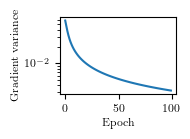

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
ax.plot(var.mean(dim=0))
ax.set_xlabel('Epoch')
ax.set_yscale('log')
ax.set_ylabel('Gradient variance')
fig.savefig('adam_variance.pdf', bbox_inches='tight')

tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])